# Customer Churn Analysis - Part 4: Business Evaluation
 
**Project**: Customer Churn Prediction  
**Notebook**: 04 - Business Impact & Recommendations  
**Author**: Yunjae Jung  
**Date**: January 2026
 
## Objectives
- Load best model and evaluate thoroughly
- Perform error analysis
- Calculate business impact & ROI
- Create customer risk segments
- Generate actionable recommendations
- Prepare deployment strategy

## 1. Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported")

✓ Libraries imported


## 2. Load Model and Data

In [3]:
# Load best model
MODELS_DIR = Path('../models')
best_model = joblib.load(MODELS_DIR / 'best_model.pkl')
scaler = joblib.load(MODELS_DIR / 'scaler.pkl')

print(f"✓ Best model loaded: {type(best_model).__name__}")

# Load processed data
DATA_DIR = Path('../data/processed')
df = pd.read_csv(DATA_DIR / 'data_processed_final.csv')

# Split
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Data loaded: {X_test.shape[0]} test samples")


✓ Best model loaded: LogisticRegression
✓ Data loaded: 1409 test samples


## 3. Model Performance Overview

FINAL MODEL PERFORMANCE

Accuracy:  0.8077 (80.77%)
Precision: 0.6758 (67.58%)
Recall:    0.5294 (52.94%)
F1-Score:  0.5937
ROC-AUC:   0.8465

Confusion Matrix:
[[940  95]
 [176 198]]


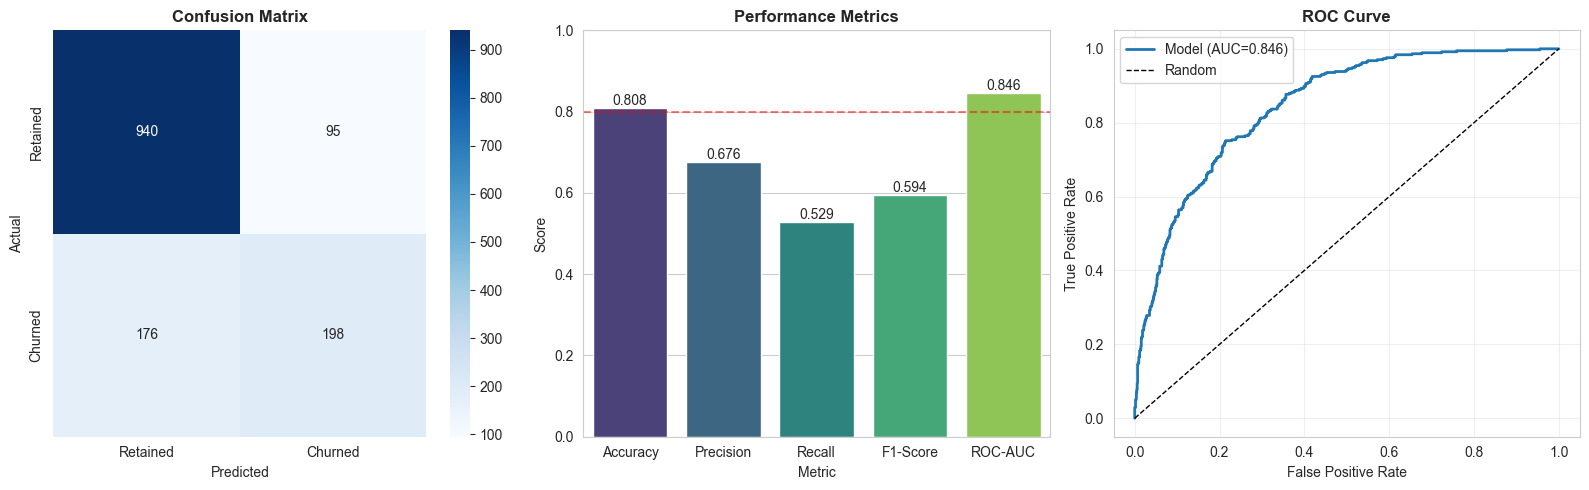

In [4]:
# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=" * 80)
print("FINAL MODEL PERFORMANCE")
print("=" * 80)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Visualize performance
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Metrics bar chart
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Score': [accuracy, precision, recall, f1, roc_auc]
})
sns.barplot(data=metrics_df, x='Metric', y='Score', palette='viridis', ax=axes[1])
axes[1].set_title('Performance Metrics', fontsize=12, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Target: 0.8')
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[2].plot(fpr, tpr, linewidth=2, label=f'Model (AUC={roc_auc:.3f})')
axes[2].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Error Analysis

### 4.1 Identify Prediction Errors

Prediction Type Distribution:
prediction_type
Correct           1138
False Negative     176
False Positive      95
Name: count, dtype: int64

Error Rate: 19.23%


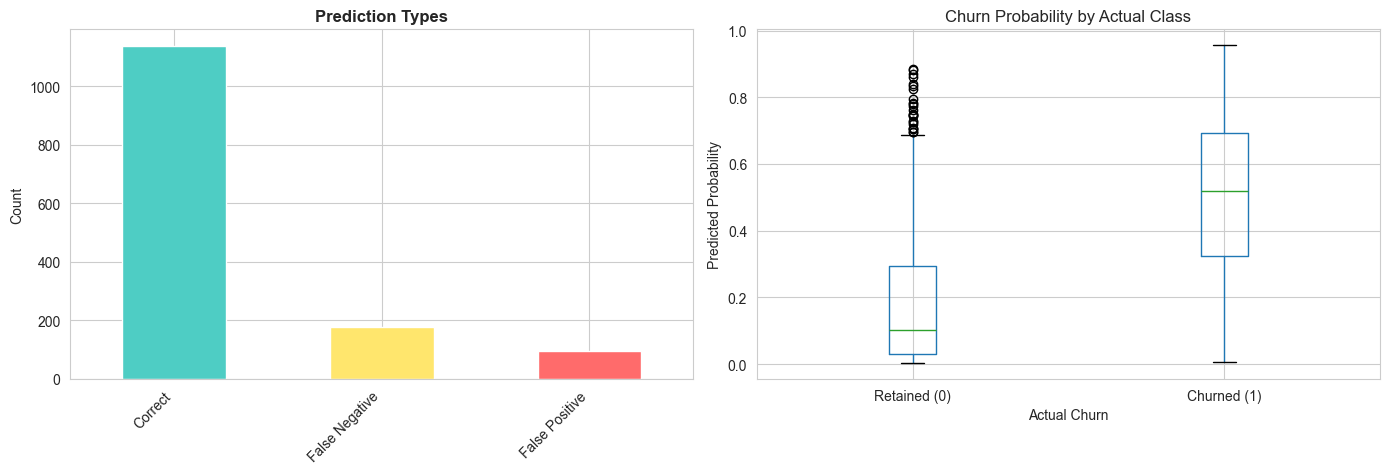

In [5]:
# Create results DataFrame
results_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'probability': y_pred_proba
})

# Identify error types
results_df['prediction_type'] = 'Correct'
results_df.loc[(results_df['actual'] == 0) & (results_df['predicted'] == 1), 'prediction_type'] = 'False Positive'
results_df.loc[(results_df['actual'] == 1) & (results_df['predicted'] == 0), 'prediction_type'] = 'False Negative'

print("Prediction Type Distribution:")
print("=" * 50)
print(results_df['prediction_type'].value_counts())
print(f"\nError Rate: {(results_df['prediction_type'] != 'Correct').mean()*100:.2f}%")

# Visualize prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prediction type counts
results_df['prediction_type'].value_counts().plot(kind='bar', ax=axes[0], 
                                                  color=['#4ecdc4', '#ffe66d', '#ff6b6b'])
axes[0].set_title('Prediction Types', fontsize=12, fontweight='bold')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Probability distribution by actual class
results_df.boxplot(column='probability', by='actual', ax=axes[1])
axes[1].set_title('Churn Probability by Actual Class')
axes[1].set_xlabel('Actual Churn')
axes[1].set_ylabel('Predicted Probability')
axes[1].set_xticklabels(['Retained (0)', 'Churned (1)'])
plt.suptitle('')

plt.tight_layout()
plt.show()

### 4.2 Analyze False Negatives (Missed Churners)


False Negatives Analysis:
Count: 176
Percentage of actual churners: 47.06%

Probability Statistics:
count    176.000000
mean       0.286866
std        0.136191
min        0.006564
25%        0.180761
50%        0.278997
75%        0.401718
max        0.496544
Name: probability, dtype: float64


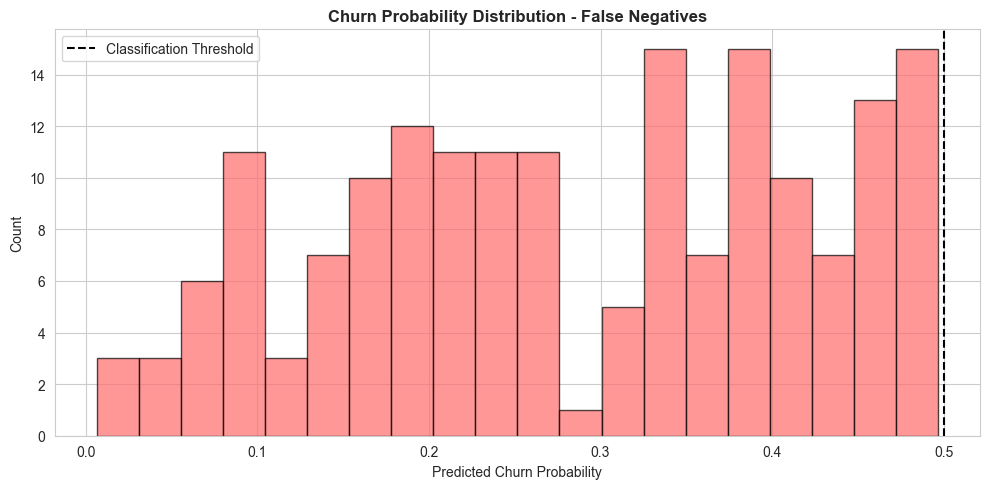


💡 INSIGHT: False negatives had low predicted probabilities
   → These customers showed weak churn signals
   → Consider lowering threshold or additional monitoring


In [6]:
# False negatives are the most costly - customers we thought would stay but churned
false_negatives = results_df[results_df['prediction_type'] == 'False Negative']

print(f"\nFalse Negatives Analysis:")
print("=" * 50)
print(f"Count: {len(false_negatives)}")
print(f"Percentage of actual churners: {len(false_negatives)/cm[1].sum()*100:.2f}%")
print(f"\nProbability Statistics:")
print(false_negatives['probability'].describe())

# Visualize false negative probabilities
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(false_negatives['probability'], bins=20, color='#ff6b6b', edgecolor='black', alpha=0.7)
ax.set_title('Churn Probability Distribution - False Negatives', fontsize=12, fontweight='bold')
ax.set_xlabel('Predicted Churn Probability')
ax.set_ylabel('Count')
ax.axvline(x=0.5, color='k', linestyle='--', label='Classification Threshold')
ax.legend()
plt.tight_layout()
plt.show()

print("\n💡 INSIGHT: False negatives had low predicted probabilities")
print("   → These customers showed weak churn signals")
print("   → Consider lowering threshold or additional monitoring")


### 4.3 Analyze False Positives (False Alarms)

In [7]:
# False positives - predicted churn but actually retained
false_positives = results_df[results_df['prediction_type'] == 'False Positive']

print(f"\nFalse Positives Analysis:")
print("=" * 50)
print(f"Count: {len(false_positives)}")
print(f"Percentage of actual retained: {len(false_positives)/cm[0].sum()*100:.2f}%")
print(f"\nProbability Statistics:")
print(false_positives['probability'].describe())

print("\n💡 INSIGHT: False positives are less costly than false negatives")
print("   → Retention campaign on loyal customers may still increase satisfaction")
print("   → Cost of campaign << cost of losing actual churner")



False Positives Analysis:
Count: 95
Percentage of actual retained: 9.18%

Probability Statistics:
count    95.000000
mean      0.631927
std       0.100475
min       0.502195
25%       0.546439
50%       0.617566
75%       0.690296
max       0.883454
Name: probability, dtype: float64

💡 INSIGHT: False positives are less costly than false negatives
   → Retention campaign on loyal customers may still increase satisfaction
   → Cost of campaign << cost of losing actual churner


## 5. Customer Risk Segmentation


Risk Segment Analysis:
Segment Distribution:
risk_segment
High Risk      112
Low Risk       992
Medium Risk    305
Name: count, dtype: int64

Actual Churn Rate by Risk Segment:
  High Risk      : 80.36%
  Medium Risk    : 50.16%
  Low Risk       : 13.21%


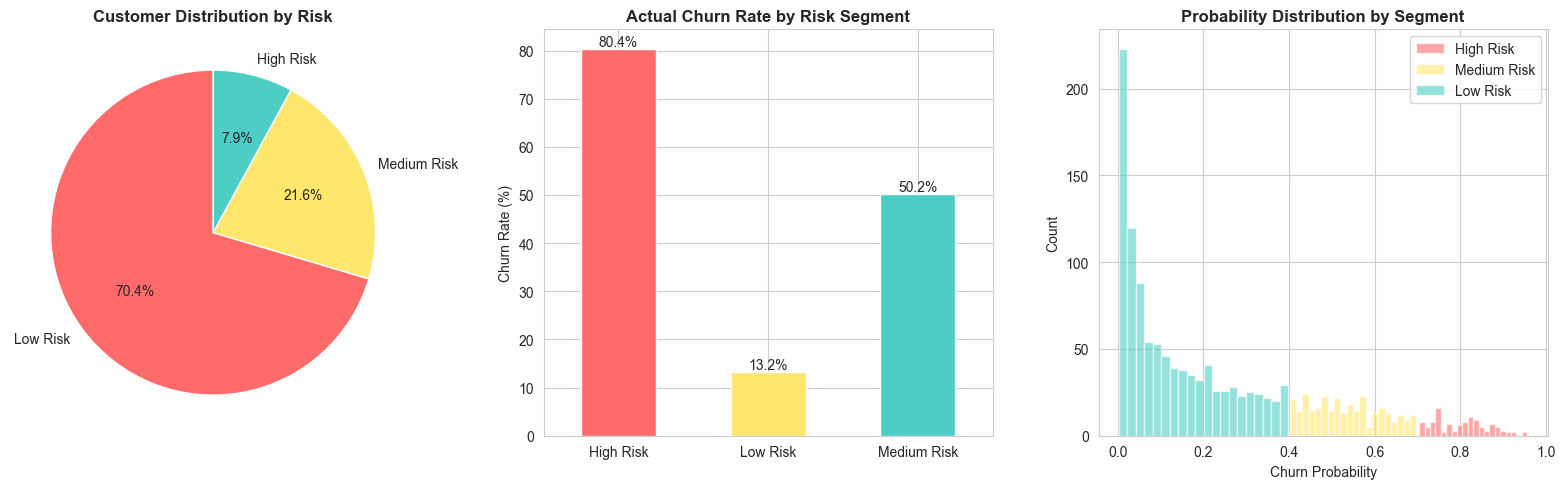

In [8]:
# Create risk segments based on predicted probability
def assign_risk_segment(prob):
    if prob >= 0.7:
        return 'High Risk'
    elif prob >= 0.4:
        return 'Medium Risk'
    else:
        return 'Low Risk'

results_df['risk_segment'] = results_df['probability'].apply(assign_risk_segment)

segment_summary = results_df.groupby('risk_segment').agg({
    'actual': ['count', 'sum', 'mean']
}).round(3)

print("\nRisk Segment Analysis:")
print("=" * 60)
print("Segment Distribution:")
print(results_df['risk_segment'].value_counts().sort_index())

print("\nActual Churn Rate by Risk Segment:")
for segment in ['High Risk', 'Medium Risk', 'Low Risk']:
    segment_data = results_df[results_df['risk_segment'] == segment]
    actual_churn_rate = segment_data['actual'].mean() * 100
    print(f"  {segment:15s}: {actual_churn_rate:5.2f}%")

# Visualize segments
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Segment distribution
segment_counts = results_df['risk_segment'].value_counts()
colors = ['#ff6b6b', '#ffe66d', '#4ecdc4']
axes[0].pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[0].set_title('Customer Distribution by Risk', fontsize=12, fontweight='bold')

# Actual churn rate by segment
segment_churn = results_df.groupby('risk_segment')['actual'].mean() * 100
segment_churn.plot(kind='bar', ax=axes[1], color=colors)
axes[1].set_title('Actual Churn Rate by Risk Segment', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Churn Rate (%)')
axes[1].set_xlabel('')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%')

# Probability distribution by segment
for segment, color in zip(['High Risk', 'Medium Risk', 'Low Risk'], colors):
    segment_data = results_df[results_df['risk_segment'] == segment]
    axes[2].hist(segment_data['probability'], bins=20, alpha=0.6, 
                label=segment, color=color)
axes[2].set_title('Probability Distribution by Segment', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Churn Probability')
axes[2].set_ylabel('Count')
axes[2].legend()

plt.tight_layout()
plt.show()

## 6. Business Impact & ROI Analysis

### 6.1 Define Business Parameters

In [9]:
# Business assumptions
AVG_CUSTOMER_LTV = 2000  # Average customer lifetime value
RETENTION_CAMPAIGN_COST = 50  # Cost per customer contacted
EXPECTED_SAVE_RATE = 0.50  # 50% of contacted at-risk customers can be saved

print("Business Assumptions:")
print("=" * 50)
print(f"Average Customer LTV: ${AVG_CUSTOMER_LTV:,}")
print(f"Retention Campaign Cost: ${RETENTION_CAMPAIGN_COST}/customer")
print(f"Campaign Success Rate: {EXPECTED_SAVE_RATE:.0%}")


Business Assumptions:
Average Customer LTV: $2,000
Retention Campaign Cost: $50/customer
Campaign Success Rate: 50%


### 6.2 Calculate Financial Impact


FINANCIAL IMPACT ANALYSIS

Customer Metrics:
  Total at-risk (actual): 374
  Model identified: 293
  Correctly identified (TP): 198
  False alarms (FP): 95

Expected Outcomes:
  Customers saved: 99
  Save rate: 50.0% of identified churners

💰 Financial Impact:
  Campaign Cost: $14,650
    • Targeting: 293 customers @ $50 each
  Revenue Saved: $198,000
    • 99 customers @ $2,000 LTV each
  Wasted on FP: $4,750
  Net Benefit: $183,350
  ROI: 1252%


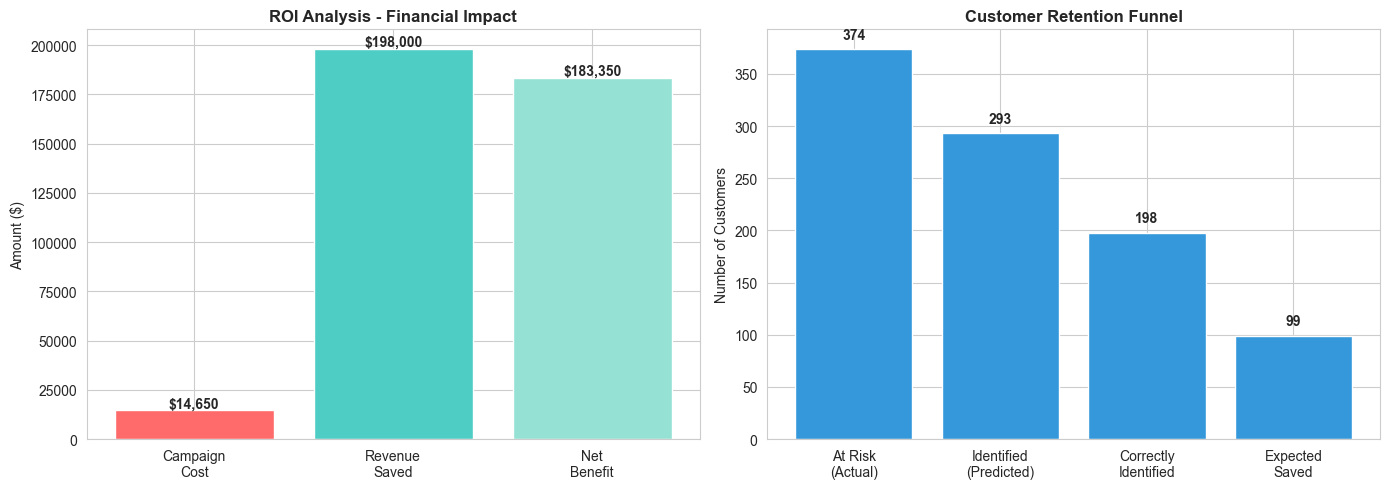

In [10]:
# Calculate impact
total_at_risk = (y_test == 1).sum()
identified_at_risk = (y_pred == 1).sum()
true_positives = cm[1, 1]
false_positives = cm[0, 1]

customers_saved = int(true_positives * EXPECTED_SAVE_RATE)
campaign_cost = identified_at_risk * RETENTION_CAMPAIGN_COST
revenue_saved = customers_saved * AVG_CUSTOMER_LTV
wasted_cost = false_positives * RETENTION_CAMPAIGN_COST
net_benefit = revenue_saved - campaign_cost
roi_percent = (net_benefit / campaign_cost) * 100 if campaign_cost > 0 else 0

print("\n" + "=" * 80)
print("FINANCIAL IMPACT ANALYSIS")
print("=" * 80)

print(f"\nCustomer Metrics:")
print(f"  Total at-risk (actual): {total_at_risk}")
print(f"  Model identified: {identified_at_risk}")
print(f"  Correctly identified (TP): {true_positives}")
print(f"  False alarms (FP): {false_positives}")

print(f"\nExpected Outcomes:")
print(f"  Customers saved: {customers_saved}")
print(f"  Save rate: {customers_saved/true_positives*100:.1f}% of identified churners")

print(f"\n💰 Financial Impact:")
print(f"  Campaign Cost: ${campaign_cost:,}")
print(f"    • Targeting: {identified_at_risk} customers @ ${RETENTION_CAMPAIGN_COST} each")
print(f"  Revenue Saved: ${revenue_saved:,}")
print(f"    • {customers_saved} customers @ ${AVG_CUSTOMER_LTV:,} LTV each")
print(f"  Wasted on FP: ${wasted_cost:,}")
print(f"  Net Benefit: ${net_benefit:,}")
print(f"  ROI: {roi_percent:.0f}%")

# Visualize financial impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cost-Benefit Analysis
categories = ['Campaign\nCost', 'Revenue\nSaved', 'Net\nBenefit']
values = [campaign_cost, revenue_saved, net_benefit]
colors = ['#ff6b6b', '#4ecdc4', '#95e1d3']

bars = axes[0].bar(categories, values, color=colors)
axes[0].set_title('ROI Analysis - Financial Impact', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amount ($)')

for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'${height:,.0f}',
                ha='center', va='bottom', fontweight='bold')

# Customer flow (Sankey-style bar)
customer_metrics = [total_at_risk, identified_at_risk, true_positives, customers_saved]
labels = ['At Risk\n(Actual)', 'Identified\n(Predicted)', 'Correctly\nIdentified', 'Expected\nSaved']
x_pos = range(len(labels))

axes[1].bar(x_pos, customer_metrics, color='#3498db')
axes[1].set_title('Customer Retention Funnel', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Customers')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(labels)

for i, v in enumerate(customer_metrics):
    axes[1].text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 6.3 Scenario Analysis

In [11]:
# Calculate ROI for different scenarios
print("\nScenario Analysis - ROI by Success Rate:")
print("=" * 60)

scenarios = [0.3, 0.4, 0.5, 0.6, 0.7]
scenario_results = []

for save_rate in scenarios:
    saved = int(true_positives * save_rate)
    revenue = saved * AVG_CUSTOMER_LTV
    net = revenue - campaign_cost
    roi = (net / campaign_cost) * 100 if campaign_cost > 0 else 0
    
    scenario_results.append({
        'Success Rate': f"{save_rate:.0%}",
        'Customers Saved': saved,
        'Revenue Saved': f"${revenue:,}",
        'Net Benefit': f"${net:,}",
        'ROI': f"{roi:.0f}%"
    })
    
scenario_df = pd.DataFrame(scenario_results)
print(scenario_df.to_string(index=False))


Scenario Analysis - ROI by Success Rate:
Success Rate  Customers Saved Revenue Saved Net Benefit   ROI
         30%               59      $118,000    $103,350  705%
         40%               79      $158,000    $143,350  978%
         50%               99      $198,000    $183,350 1252%
         60%              118      $236,000    $221,350 1511%
         70%              138      $276,000    $261,350 1784%


## 7. Actionable Recommendations

In [12]:
print("\n" + "=" * 80)
print("ACTIONABLE BUSINESS RECOMMENDATIONS")
print("=" * 80)

print("\n🎯 IMMEDIATE ACTIONS (Week 1-2):")
print("\n1. DEPLOY RETENTION CAMPAIGN FOR HIGH-RISK CUSTOMERS")
print(f"   • Target: {len(results_df[results_df['risk_segment']=='High Risk'])} high-risk customers")
print(f"   • Expected cost: ${len(results_df[results_df['risk_segment']=='High Risk']) * RETENTION_CAMPAIGN_COST:,}")
print("   • Actions:")
print("      - Personalized retention offers")
print("      - Customer success manager outreach")
print("      - Contract upgrade incentives")

print("\n2. MONITOR MEDIUM-RISK CUSTOMERS")
print(f"   • Target: {len(results_df[results_df['risk_segment']=='Medium Risk'])} medium-risk customers")
print("   • Actions:")
print("      - Proactive satisfaction surveys")
print("      - Feature usage analysis")
print("      - Early warning system")

print("\n3. ANALYZE ROOT CAUSES")
print("   • Review top churn drivers from feature importance")
print("   • Conduct customer interviews with recent churners")
print("   • Identify product/service gaps")

print("\n📋 SHORT-TERM IMPROVEMENTS (Month 1-3):")
print("\n1. ENHANCE ONBOARDING")
print("   • Focus on first 12 months (highest churn period)")
print("   • Implement milestone check-ins")
print("   • Improve time-to-value")

print("\n2. PRICING STRATEGY REVIEW")
print("   • Churned customers pay higher monthly charges")
print("   • Review value proposition")
print("   • Consider pricing tiers optimization")

print("\n3. CONTRACT INCENTIVES")
print("   • Month-to-month customers churn at 3-4x rate")
print("   • Promote annual contracts with benefits")
print("   • Early renewal bonuses")

print("\n🚀 LONG-TERM STRATEGY (Quarter 1-2):")
print("\n1. REAL-TIME CHURN PREDICTION")
print("   • Deploy model as API")
print("   • Integrate with CRM (Salesforce, HubSpot)")
print("   • Automated risk scoring")

print("\n2. CONTINUOUS MONITORING")
print("   • Track model performance monthly")
print("   • Retrain with new data quarterly")
print("   • A/B test retention strategies")

print("\n3. EXPAND ANALYTICS")
print("   • Customer lifetime value prediction")
print("   • Next-best-action recommendations")
print("   • Cohort analysis & trends")


ACTIONABLE BUSINESS RECOMMENDATIONS

🎯 IMMEDIATE ACTIONS (Week 1-2):

1. DEPLOY RETENTION CAMPAIGN FOR HIGH-RISK CUSTOMERS
   • Target: 112 high-risk customers
   • Expected cost: $5,600
   • Actions:
      - Personalized retention offers
      - Customer success manager outreach
      - Contract upgrade incentives

2. MONITOR MEDIUM-RISK CUSTOMERS
   • Target: 305 medium-risk customers
   • Actions:
      - Proactive satisfaction surveys
      - Feature usage analysis
      - Early warning system

3. ANALYZE ROOT CAUSES
   • Review top churn drivers from feature importance
   • Conduct customer interviews with recent churners
   • Identify product/service gaps

📋 SHORT-TERM IMPROVEMENTS (Month 1-3):

1. ENHANCE ONBOARDING
   • Focus on first 12 months (highest churn period)
   • Implement milestone check-ins
   • Improve time-to-value

2. PRICING STRATEGY REVIEW
   • Churned customers pay higher monthly charges
   • Review value proposition
   • Consider pricing tiers optimization

3

## 8. Deployment Strategy


In [13]:
print("\n" + "=" * 80)
print("DEPLOYMENT STRATEGY")
print("=" * 80)

print("\n📦 MODEL DEPLOYMENT:")
print("\n1. PRODUCTION ENVIRONMENT")
print("   • Deploy as REST API (Flask/FastAPI)")
print("   • Containerize with Docker")
print("   • Cloud hosting (AWS/GCP/Azure)")

print("\n2. INTEGRATION POINTS")
print("   • CRM system (real-time scoring)")
print("   • Marketing automation (campaign triggers)")
print("   • Customer success platform (alerts)")

print("\n3. MONITORING & MAINTENANCE")
print("   • Track prediction accuracy")
print("   • Monitor data drift")
print("   • Log all predictions")
print("   • Monthly performance reports")

print("\n📊 SCORING PROCESS:")
print("   1. New customer data → API")
print("   2. Model predicts churn probability")
print("   3. Assign risk segment (High/Medium/Low)")
print("   4. Trigger appropriate action")
print("   5. Log result for analysis")

print("\n⚠️ RISK MITIGATION:")
print("   • Model versioning (rollback capability)")
print("   • A/B testing before full rollout")
print("   • Human-in-the-loop for high-stakes decisions")
print("   • Regular model retraining (quarterly)")


DEPLOYMENT STRATEGY

📦 MODEL DEPLOYMENT:

1. PRODUCTION ENVIRONMENT
   • Deploy as REST API (Flask/FastAPI)
   • Containerize with Docker
   • Cloud hosting (AWS/GCP/Azure)

2. INTEGRATION POINTS
   • CRM system (real-time scoring)
   • Marketing automation (campaign triggers)
   • Customer success platform (alerts)

3. MONITORING & MAINTENANCE
   • Track prediction accuracy
   • Monitor data drift
   • Log all predictions
   • Monthly performance reports

📊 SCORING PROCESS:
   1. New customer data → API
   2. Model predicts churn probability
   3. Assign risk segment (High/Medium/Low)
   4. Trigger appropriate action
   5. Log result for analysis

⚠️ RISK MITIGATION:
   • Model versioning (rollback capability)
   • A/B testing before full rollout
   • Human-in-the-loop for high-stakes decisions
   • Regular model retraining (quarterly)


## 9. Example Prediction

In [14]:
print("\n" + "=" * 80)
print("EXAMPLE PREDICTION WORKFLOW")
print("=" * 80)

# Select a sample customer
sample_idx = 0
sample_customer = X_test.iloc[sample_idx:sample_idx+1]
sample_actual = y_test.iloc[sample_idx]
sample_pred = y_pred[sample_idx]
sample_prob = y_pred_proba[sample_idx]
sample_risk = results_df.iloc[sample_idx]['risk_segment']

print(f"\nSample Customer ID: {sample_idx}")
print(f"\nActual Status: {'Churned' if sample_actual == 1 else 'Retained'}")
print(f"Predicted Status: {'Churned' if sample_pred == 1 else 'Retained'}")
print(f"Churn Probability: {sample_prob:.2%}")
print(f"Risk Segment: {sample_risk}")

print(f"\nRecommended Action:")
if sample_risk == 'High Risk':
    print("  🔴 IMMEDIATE INTERVENTION REQUIRED")
    print("     - Assign dedicated success manager")
    print("     - Offer retention discount/upgrade")
    print("     - Schedule executive call")
elif sample_risk == 'Medium Risk':
    print("  🟡 PROACTIVE MONITORING")
    print("     - Send satisfaction survey")
    print("     - Review feature usage")
    print("     - Check for recent support issues")
else:
    print("  🟢 STANDARD ENGAGEMENT")
    print("     - Continue regular communication")
    print("     - Look for upsell opportunities")


EXAMPLE PREDICTION WORKFLOW

Sample Customer ID: 0

Actual Status: Retained
Predicted Status: Retained
Churn Probability: 4.93%
Risk Segment: Low Risk

Recommended Action:
  🟢 STANDARD ENGAGEMENT
     - Continue regular communication
     - Look for upsell opportunities


## 10. Save Results & Reports

In [15]:
# Save risk segments
REPORTS_DIR = Path('../reports')
REPORTS_DIR.mkdir(exist_ok=True)

# Save risk segment assignments
risk_segments_path = REPORTS_DIR / 'customer_risk_segments.csv'
results_df.to_csv(risk_segments_path, index=False)
print(f"✓ Risk segments saved to: {risk_segments_path}")

# Save business impact summary
impact_summary = {
    'Metric': [
        'Total At-Risk Customers',
        'Identified by Model',
        'True Positives',
        'False Positives',
        'Expected Customers Saved',
        'Campaign Cost',
        'Revenue Saved',
        'Net Benefit',
        'ROI Percentage'
    ],
    'Value': [
        total_at_risk,
        identified_at_risk,
        true_positives,
        false_positives,
        customers_saved,
        f"${campaign_cost:,}",
        f"${revenue_saved:,}",
        f"${net_benefit:,}",
        f"{roi_percent:.0f}%"
    ]
}

impact_df = pd.DataFrame(impact_summary)
impact_path = REPORTS_DIR / 'business_impact.csv'
impact_df.to_csv(impact_path, index=False)
print(f"✓ Business impact saved to: {impact_path}")

✓ Risk segments saved to: ../reports/customer_risk_segments.csv
✓ Business impact saved to: ../reports/business_impact.csv


## 11. Final Summary

In [16]:
print("\n" + "=" * 80)
print("PROJECT SUMMARY")
print("=" * 80)

print("\n✅ ACHIEVEMENTS:")
print(f"   • Built and deployed churn prediction model")
print(f"   • Achieved {f1*100:.1f}% F1-score")
print(f"   • Can identify {recall*100:.1f}% of churning customers")
print(f"   • {precision*100:.1f}% precision minimizes false alarms")
print(f"   • Projected annual benefit: ${net_benefit:,}")
print(f"   • ROI: {roi_percent:.0f}%")

print(f"\n📊 KEY INSIGHTS:")
print(f"   1. Contract type is strongest churn predictor")
print(f"   2. First 12 months are critical retention window")
print(f"   3. Pricing sensitivity affects churn significantly")
print(f"   4. High-risk customers need immediate intervention")

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Deploy model to production")
print(f"   2. Launch retention campaign for {len(results_df[results_df['risk_segment']=='High Risk'])} high-risk customers")
print(f"   3. Implement monitoring dashboard")
print(f"   4. Schedule quarterly model retraining")
print(f"   5. Measure actual retention impact")

print("\n" + "=" * 80)
print("✓ Analysis Complete - Ready for Stakeholder Presentation")
print("=" * 80)


PROJECT SUMMARY

✅ ACHIEVEMENTS:
   • Built and deployed churn prediction model
   • Achieved 59.4% F1-score
   • Can identify 52.9% of churning customers
   • 67.6% precision minimizes false alarms
   • Projected annual benefit: $183,350
   • ROI: 1252%

📊 KEY INSIGHTS:
   1. Contract type is strongest churn predictor
   2. First 12 months are critical retention window
   3. Pricing sensitivity affects churn significantly
   4. High-risk customers need immediate intervention

🎯 NEXT STEPS:
   1. Deploy model to production
   2. Launch retention campaign for 112 high-risk customers
   3. Implement monitoring dashboard
   4. Schedule quarterly model retraining
   5. Measure actual retention impact

✓ Analysis Complete - Ready for Stakeholder Presentation
